In [17]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense, Resizing
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
tf.keras.utils.set_random_seed(9)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
print("Device:", tpu.master())

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.7.248.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.7.248.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Device: grpc://10.7.248.226:8470


In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [5]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#getting dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [8]:
#checking train and test size
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


# Data Preprocessing

In [9]:
#use train_test_split to create validation set.
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=10
                                                                              ,shuffle=True)

In [10]:
#looking at train, validation and test set shapes
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [ ]:
#The ResNet50 model requires that the inputs not be scaled

#x_train_norm = x_train_split/255
#x_valid_norm = x_valid_split/255
#x_test_norm = x_test/255

# Helpful Model Fitting and Results Functions

In [11]:
#creating callback class to get the amount of seconds each epoch takes. Code from:
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class EpochTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [12]:
def compile_train_model(model, x_train, y_train, x_valid, y_valid, model_num, epochs=100, patience=3):
    timestamp=int(time.time())
    epoch_times=EpochTimeHistory()
  
    # Compile
    model.compile(optimizer='adam',
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
    start_time = time.time()
    history = model.fit(
      x_train,
      y_train,
      epochs=epochs,
      batch_size=512,
      validation_data=(x_valid, y_valid),
      verbose=1,
      callbacks=[    
          EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=2),
          
        epoch_times]
       )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)
    epoch_times_values =epoch_times.times
    print("\n")
    print(f'Finished model training in {second_elapsed}s')
    print(f'Average time to run each epoch is: {  np.round(np.mean(epoch_times.times[1:-1]),4) }') 
                                                                        
  

    return history, model

In [13]:
#Classificatin report function
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))#included per class instruction 

In [14]:
#function to print out training and validation set loss and accuracy values of the best model
def loss_accuracy_values(model_history, model_num, epochs, patience=3):  
  if len(model_history.history["val_loss"])==epochs:
      print("Model Experiment {} Training Loss: ".format(model_num),np.round(model_history.history["loss"][-1],4))
      print("Model Experiment {} Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-1],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num),np.round(model_history.history["val_loss"][-1],4))
      print("Model Experiment {}  Validation Accuracy: ".format(model_num),np.round(model_history.history["val_accuracy"][-1],4))
  else:
      print("Model Experiment {}  Training Loss: ".format(model_num),np.round(model_history.history["loss"][-(1+patience)],4))
      print("Model Experiment {}  Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-(1+patience)],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num), np.round(model_history.history["val_loss"][-(1+patience)],4))
      print("Model Experiment {}  Validation Accuracy:".format(model_num), np.round(model_history.history["val_accuracy"][-(1+patience)],4)) 

In [15]:
#creating function for charts of train vs validation accuracy and loss functions
def train_val_accuracy_and_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Loss".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    model_df[["accuracy","val_accuracy"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Accuracy".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [16]:
# Function for creating multi-class confusion matrix

#class names for confusion matrix
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']



def confusion_matrix_multi_class(model_for_matrix,test_set, actual_test_labels, model_num):
    #predicting test set with model for confusion matrix and setting as sparse with argmax
    confusion_matrix_predictions=model_for_matrix.predict(test_set).argmax(axis=1)



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix( actual_test_labels ,  confusion_matrix_predictions)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                     #index = [0,1,2,3,4,5,6,7,8,9], 
                     #columns = [0,1,2,3,4,5,6,7,8,9]
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="rocket_r")
    plt.title('Confusion Matrix - Model Experiment {}'.format(model_num), size=17)
    plt.ylabel('Actual Labels', size=15)
    plt.xlabel('Predicted Labels',size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# Experiment 7 - ResNet50 Convolutional Pre-trained Layers and Two Trainable Dense Layers with Dropout. 

In [28]:
#Experiment 7 model
#ResNet50 model with top (flattened) layers trained only
def create_model_exp_7():
    model = Sequential()
    model.add(Input(shape=(32,32,3)))
    model.add(Resizing(224,224))#ResNet50 requires 224x224 pixel images
    model.add(ResNet50(include_top=False, pooling='max', weights="imagenet"))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(256, activation ='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(10, activation="softmax"))
   
    model.layers[1].trainable = False

    return model



In [19]:
#set up TPU strategy
strategy_exp_7  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [29]:
#create model for TPU strategy
with strategy_exp_7.scope():
    model_exp_7 = create_model_exp_7()

model_exp_7.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               524544    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)              

In [30]:
# Compile and train
epochs=100
patience=3
model_number="7"
history_exp_7, model_exp_7 = compile_train_model(model_exp_7,
                                     x_train_split, y_train_split,
                                     x_valid_split, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
 6/88 [=>............................] - ETA: 4s - loss: 8.5058 - accuracy: 0.1572WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0034s vs `on_train_batch_end` time: 1.1867s). Check your callbacks.


88/88 [==============================] - 41s 326ms/step - loss: 1.7242 - accuracy: 0.5691 - val_loss: 0.6457 - val_accuracy: 0.7842
Epoch 2/100
88/88 [==============================] - 8s 86ms/step - loss: 0.7053 - accuracy: 0.7609 - val_loss: 0.5418 - val_accuracy: 0.8146
Epoch 3/100
88/88 [==============================] - 8s 85ms/step - loss: 0.5965 - accuracy: 0.7970 - val_loss: 0.4828 - val_accuracy: 0.8360
Epoch 4/100
88/88 [==============================] - 8s 85ms/step - loss: 0.5211 - accuracy: 0.8223 - val_loss: 0.4699 - val_accuracy: 0.8388
Epoch 5/100
88/88 [==============================] - 7s 85ms/step - loss: 0.4788 - accuracy: 0.8358 - val_loss: 0.4447 - val_accuracy: 0.8500
Epoch 6/100
88/88 [==============================] - 7s 84ms/step - loss: 0.4342 - accuracy: 0.8510 - val_loss: 0.4230 - val_accuracy: 0.8556
Epoch 7/100
88/88 [==============================] - 6s 69ms/step - loss: 0.4152 - accuracy: 0.8572 - val_loss: 0.4263 - val_accuracy: 0.8524
Epoch 8/100
88/8

In [31]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_7, model_number, epochs, patience=patience)

Model Experiment 7  Training Loss:  0.3381
Model Experiment 7  Training Accuracy:  0.8822
Model Experiment 7  Validation Loss:  0.4164
Model Experiment 7  Validation Accuracy: 0.8634


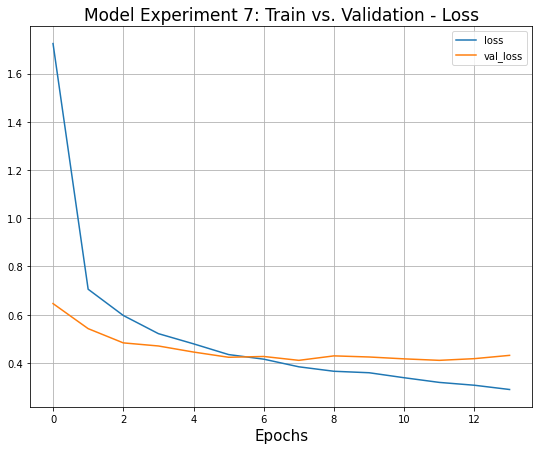

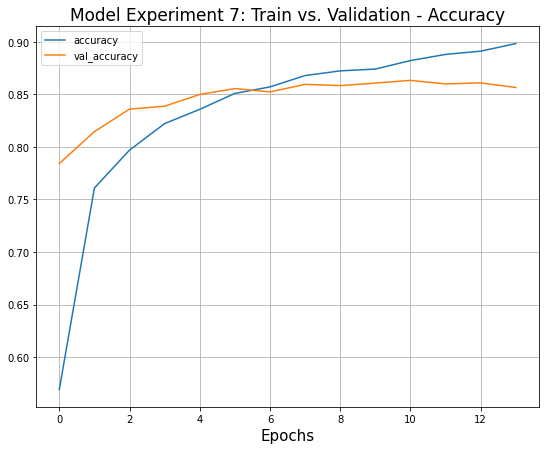

In [32]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_7, model_number)

In [33]:
#creating  classification report

#getting predictions

model_exp_7_predictions=model_exp_7.predict(x_test).argmax(axis=1)
print_validation_report(y_test, model_exp_7_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1000
           1       0.91      0.94      0.92      1000
           2       0.82      0.86      0.84      1000
           3       0.77      0.68      0.72      1000
           4       0.82      0.86      0.84      1000
           5       0.81      0.79      0.80      1000
           6       0.85      0.93      0.89      1000
           7       0.90      0.89      0.89      1000
           8       0.90      0.91      0.91      1000
           9       0.93      0.89      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy Score: 0.8618
Root Mean Square Error: 1.5378556499229699


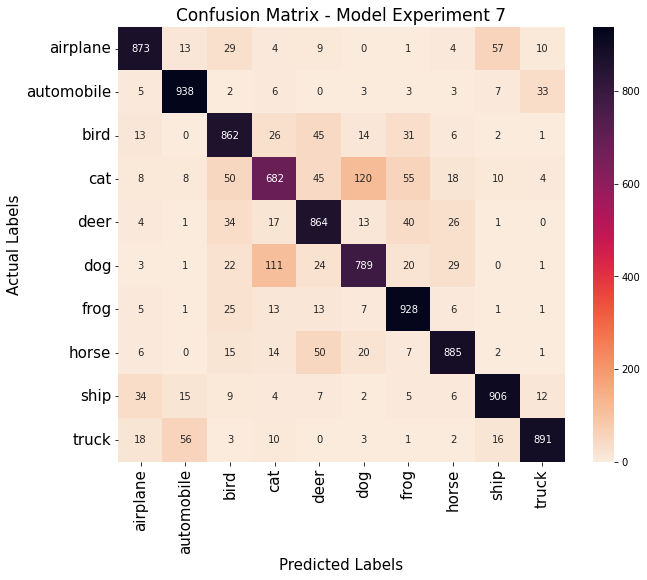

In [34]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_7, x_test, y_test, model_number)